# Visual Introduction to CIGALE

This notebook presents the Spectral Energy Distribution (SED) creation in CIGALE.  At first, we create a SED step by step chaining the various modules.  Then we show what information is available in the SED and how CIGALE makes it easy to compute fluxes in different bands.  Finaly, we will use an interactive plot to experiment with the effects fo the various parameters.

In [1]:
#%pylab widget
#matplotlib.rcParams['figure.figsize'] = [9.,6.]

In [2]:
from copy import deepcopy

import numpy as np

from IPython.display import display
from ipywidgets import widgets
from matplotlib import pyplot as plt

from astropy.table import Table

from pcigale import sed
from pcigale import sed_modules as modules
from pcigale.warehouse import SedWarehouse

## 1. Creating a SED step by step

`SED_PARAMETERS` contains all the modules that are used with their parameters, stored in a dictionary for easier reuse. You can change the values (_for valid ones_) before running the notebook.

_Note: as we are processing a SED step by step, the cell must be executed in order and not re-excuted._

In [3]:
SED_PARAMETERS = {
    'sfhdelayed': {
        'tau_main': 1000.,
        'age_main': 8000.,
        'tau_burst': 2000.,
        'age_burst': 50.,
        'f_burst': 0.,
        },
    'bc03': {
        'imf': 0,
        'metallicity': 0.02,
    },
    'nebular': {
        'logU': -2.0,
        'f_esc': 0.0,
        'f_dust': 0.0,
        'emission': True,
    },
    'dustatt_modified_starburst': {
        'E_BV_lines': 0.08,
        'E_BV_factor': 1,
        'uv_bump_wavelength': 217.5,
        'uv_bump_width': 35.0,
        'uv_bump_amplitude': 0.0,
        'powerlaw_slope': 0.0,
        'Ext_law_emission_lines': 1,
        'Rv': 3.1,
    },
    'dl2014': {
        'qpah': 2.50,
        'umin': 1.5,
        'alpha': 2.0,
        'gamma': 0.02,
    },
    'redshifting': {
        'redshift': 2,
    }
}

We start with an empty SED.

In [4]:
gal = sed.SED()

### 1.a Star Formation History (SFH)

The SFH module is for generating the history of the star formation, _i.e._ the evolution of the Star Formation Rate (SFR) in the time.

In [5]:
mod = modules.get_module('sfhdelayed', **SED_PARAMETERS['sfhdelayed'])
mod.process(gal)

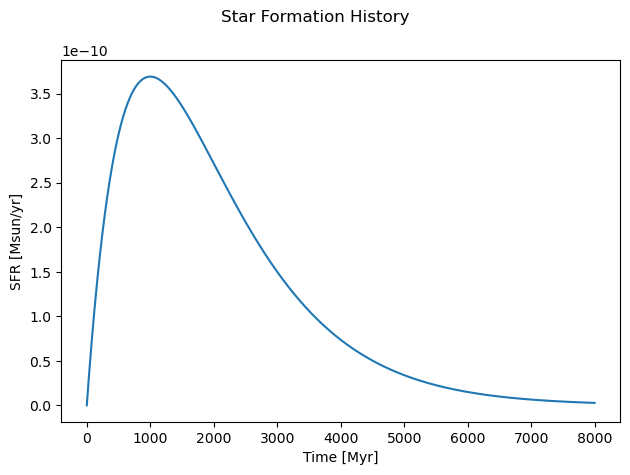

In [6]:
plt.figure()
plt.plot(gal.sfh)
plt.xlabel ("Time [Myr]")
plt.ylabel("SFR [Msun/yr]")
plt.suptitle("Star Formation History")
plt.tight_layout()
_ = plt.show()

### 1.b Stellar Emission

The stellar population module is responsible for the emission of the stars produced during the SFH.

In [7]:
mod = modules.get_module('bc03',**SED_PARAMETERS['bc03'])
mod.process(gal)

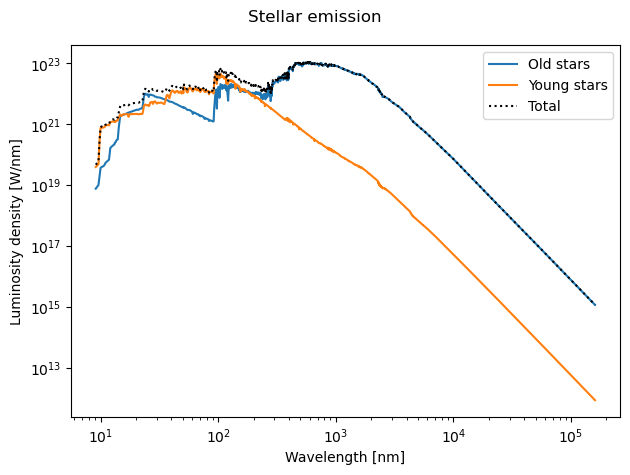

In [8]:
plt.figure()
plt.loglog(gal.wavelength_grid, gal.luminosities['stellar.old'], label="Old stars")
plt.loglog(gal.wavelength_grid, gal.luminosities['stellar.young'], label="Young stars")
plt.loglog(gal.wavelength_grid, gal.luminosity, 'k:', label="Total")
plt.ylabel ("Luminosity density [W/nm]")
plt.xlabel("Wavelength [nm]")
plt.legend(loc=0)
plt.suptitle("Stellar emission")
plt.tight_layout()
_ = plt.show()

### 1.c Nebular Emission

The nebular module is responsible for the effets of the nebular clouds that absorbs some light from the stars re-emitting the energy as emission lines plus a nebular continuum.

In [9]:
mod = modules.get_module('nebular',**SED_PARAMETERS['nebular'])
mod.process(gal)

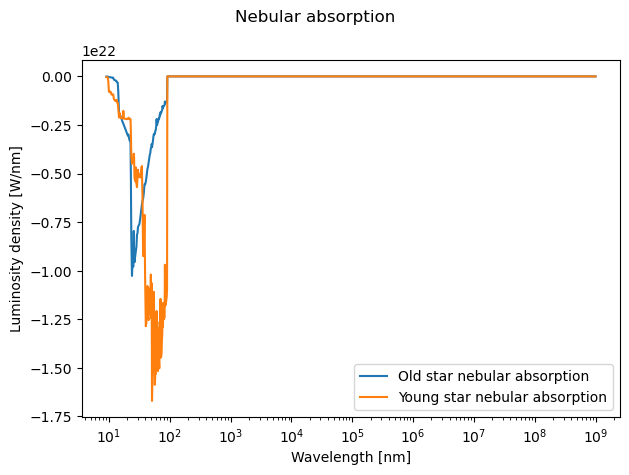

In [10]:
plt.figure()
plt.semilogx(gal.wavelength_grid, gal.luminosities['nebular.absorption_old'], label="Old star nebular absorption")
plt.semilogx(gal.wavelength_grid, gal.luminosities['nebular.absorption_young'], label="Young star nebular absorption")
plt.ylabel ("Luminosity density [W/nm]")
plt.xlabel("Wavelength [nm]")
plt.legend(loc=0)
plt.suptitle("Nebular absorption")
plt.tight_layout()
_ = plt.show()

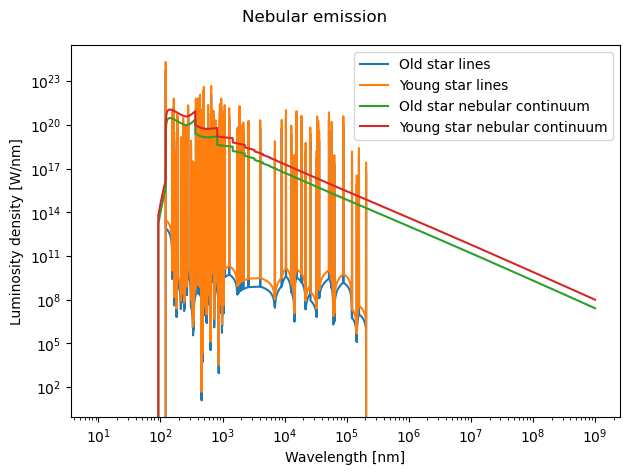

In [11]:
plt.figure()
plt.loglog(gal.wavelength_grid, gal.luminosities['nebular.lines_old'], label="Old star lines")
plt.loglog(gal.wavelength_grid, gal.luminosities['nebular.lines_young'], label="Young star lines")
plt.loglog(gal.wavelength_grid, gal.luminosities['nebular.continuum_old'], label="Old star nebular continuum")
plt.loglog(gal.wavelength_grid, gal.luminosities['nebular.continuum_young'], label="Young star nebular continuum")
plt.ylabel ("Luminosity density [W/nm]")
plt.xlabel("Wavelength [nm]")
plt.legend(loc=0)
plt.suptitle("Nebular emission")
plt.tight_layout()
_ = plt.show()

### 1.d Dust absorption

The dust absorption module is responsible for the intra-galactic dust attenuation.  For clarity, we are making two graph, one with the attunation of the stellar components and one for the nebular one.

In [12]:
mod = modules.get_module('dustatt_modified_starburst',**SED_PARAMETERS['dustatt_modified_starburst'])
mod.process(gal)

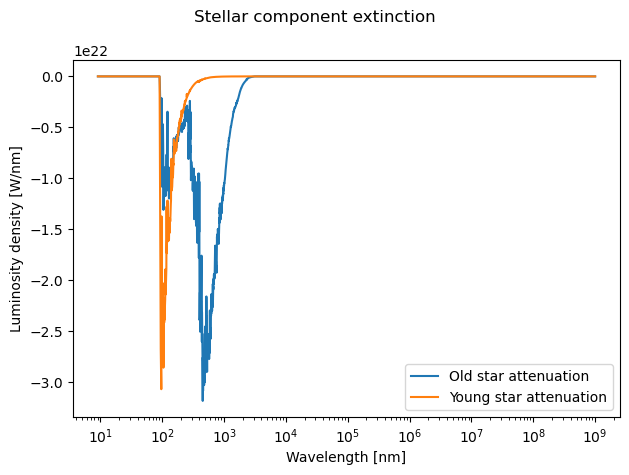

In [13]:
plt.figure()
plt.semilogx(gal.wavelength_grid, gal.luminosities['attenuation.stellar.old'], label="Old star attenuation")
plt.semilogx(gal.wavelength_grid, gal.luminosities['attenuation.stellar.young'], label="Young star attenuation")
plt.ylabel ("Luminosity density [W/nm]")
plt.xlabel("Wavelength [nm]")
plt.legend()
plt.suptitle("Stellar component extinction")
plt.tight_layout()
_ = plt.show()

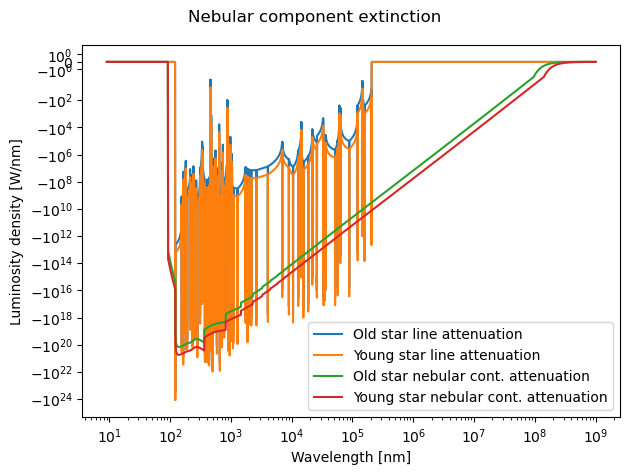

In [14]:
plt.figure()
plt.semilogx(gal.wavelength_grid, gal.luminosities['attenuation.nebular.lines_old'], label="Old star line attenuation")
plt.semilogx(gal.wavelength_grid, gal.luminosities['attenuation.nebular.lines_young'], label="Young star line attenuation")
plt.semilogx(gal.wavelength_grid, gal.luminosities['attenuation.nebular.continuum_old'], label="Old star nebular cont. attenuation")
plt.semilogx(gal.wavelength_grid, gal.luminosities['attenuation.nebular.continuum_young'], label="Young star nebular cont. attenuation")
plt.ylabel ("Luminosity density [W/nm]")
plt.xlabel("Wavelength [nm]")
plt.yscale('symlog')
plt.legend()
plt.suptitle("Nebular component extinction")
plt.tight_layout()
_ = plt.show()

### 1.e IR Re-emission

The IR re-emission module is responsible for the re-emission to the same energy that was absorbed (the enery balance) in the infra-red by the dust.

In [15]:
mod = modules.get_module('dl2014',**SED_PARAMETERS['dl2014'])
mod.process(gal)

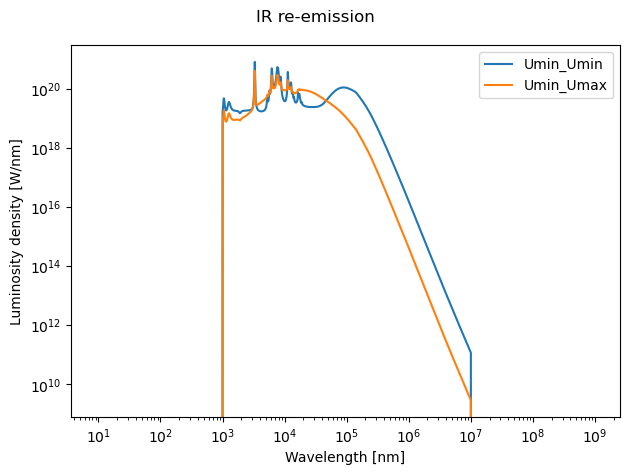

In [16]:
plt.figure()
plt.loglog(gal.wavelength_grid, gal.luminosities['dust.Umin_Umin'], label="Umin_Umin")
plt.loglog(gal.wavelength_grid, gal.luminosities['dust.Umin_Umax'], label="Umin_Umax")
plt.ylabel ("Luminosity density [W/nm]")
plt.xlabel("Wavelength [nm]")
plt.legend()
plt.suptitle("IR re-emission")
plt.tight_layout()
_ = plt.show()

### 1.f Rest-frame spectrum

At the end, we have a restframe galaxy with this luminosity spectrum.

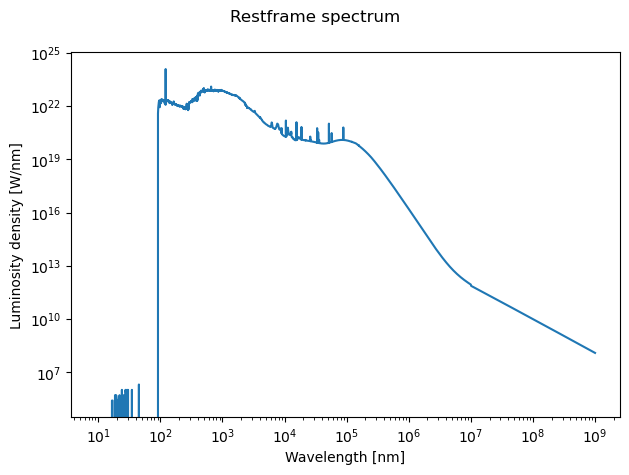

In [17]:
plt.figure()
plt.loglog(gal.wavelength_grid, gal.luminosity, label="Restframe luminosity")
plt.ylabel ("Luminosity density [W/nm]")
plt.xlabel("Wavelength [nm]")
plt.suptitle("Restframe spectrum")
plt.tight_layout()
_ = plt.show()

### 1.g Redshift and IGM effect

The redshifting module is here to redshift the SED and apply the effect of the inter-galactic medium during the travel of the light.  Note that the graphics are in flux and not in luminosity, that's why the redshifted galaxy appears to have a lower emission.

In [18]:
# We make a copy of the rest-frame galaxy to compare in the plot.
gal_restframe = deepcopy(gal)

mod = modules.get_module('redshifting',**SED_PARAMETERS['redshifting'])
mod.process(gal)

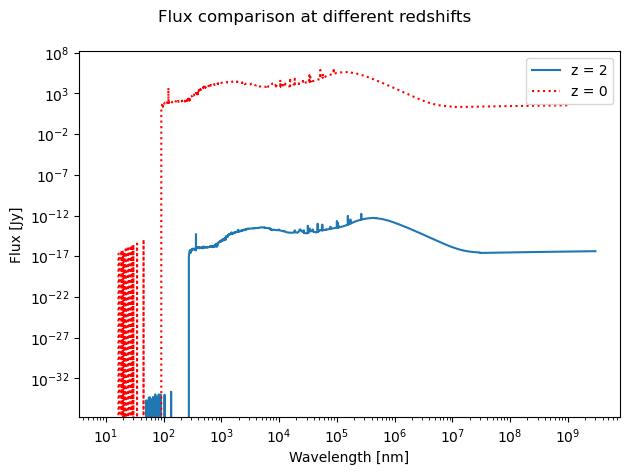

In [19]:
plt.figure()
plt.loglog(gal.wavelength_grid, gal.fnu, label=f"z = {SED_PARAMETERS['redshifting']['redshift']}")
plt.loglog(gal_restframe.wavelength_grid, gal_restframe.fnu, color="r", ls=":", label="z = 0")
plt.ylabel ("Flux [Jy]")
plt.xlabel("Wavelength [nm]")
plt.legend(loc=0)
plt.suptitle("Flux comparison at different redshifts")
plt.tight_layout()
_ = plt.show()

## 2 Information available in the SED

In [20]:
for key in sorted(gal.info):
    print("%s: %s" % (key, gal.info[key]))

attenuation.B_B90: 0.3983628630998207
attenuation.E_BV_factor: 1.0
attenuation.E_BV_lines: 0.08
attenuation.E_BVs: 0.08
attenuation.FUV: 0.8111110179347175
attenuation.V_B90: 0.3229933951152755
attenuation.powerlaw_slope: 0.0
attenuation.uv_bump_amplitude: 0.0
attenuation.uv_bump_wavelength: 217.5
attenuation.uv_bump_width: 35.0
dust.alpha: 2.0
dust.gamma: 0.02
dust.luminosity: 2.0447954716577334e+25
dust.mass: 3.749261730254862e+26
dust.qpah: 2.5
dust.umean: 1.9413789869923526
dust.umin: 1.5
nebular.f_dust: 0.0
nebular.f_esc: 0.0
nebular.lines_width: 300.0
nebular.logU: -2.0
nebular.ne: 100.0
nebular.zgas: 0.02
sfh.age: 8000
sfh.age_burst: 50
sfh.age_main: 8000
sfh.f_burst: 0.0
sfh.integrated: 1.0
sfh.sfr: 2.6941883039202324e-12
sfh.sfr100Myrs: 2.8142653683759147e-12
sfh.sfr10Myrs: 2.704825330758137e-12
sfh.tau_burst: 2000.0
sfh.tau_main: 1000.0
stellar.age_m_star: 6006.249511533762
stellar.imf: 0
stellar.lum: 1.3200934337587595e+26
stellar.lum_ly: 1.0539451823909753e+24
stellar.lum_l

## 3 Integration of flux in filters

CIGALE has a database of filter band-passes an makes it easy to compute the SED flux in them.

_Note: the fluxes are really low because we constructed a galaxy of 1 Solar mass. ;-)_

In [21]:
from pcigale.data import SimpleDatabase
base = SimpleDatabase('filters')

f_ = {}
filter_list =["NUV", "UX_B90", "BX_B90", "V_B90", "RJ", "z_prime", "J", "K", "IRAC1", "IRAC2", "IRAC3", "IRAC4", "MIPS1"]

for name in filter_list:
    f_[name] = base.get(name=name)

In [22]:
fmod = {}

for name in filter_list:
    fmod[name] = gal.compute_fnu(name)
    print("{}: {:3.5g} Jy".format(name, fmod[name]))


NUV: 8.4126e-19 Jy
UX_B90: 1.1732e-16 Jy
BX_B90: 1.1651e-16 Jy
V_B90: 1.299e-16 Jy
RJ: 1.5789e-16 Jy
z_prime: 4.8771e-16 Jy
J: 2.4825e-15 Jy
K: 1.365e-14 Jy
IRAC1: 2.6914e-14 Jy
IRAC2: 3.1796e-14 Jy
IRAC3: 3.2175e-14 Jy
IRAC4: 1.9685e-14 Jy
MIPS1: 1.2717e-14 Jy


## 4 Interactive SED

This last plot allows you to interact with the module parameters to experiment with their effects on the final spectrum.  The dotted line is the SED we just created while the plain line is the one made with the parameters you changed.  At the beginning, they should be exactly the same.  To start over, re-execute the cell.

In [23]:
WAREHOUSE = SedWarehouse()

def plot_sed(tau_main, age_main, tau_burst, age_burst, f_burst, metallicity, logU, f_esc, f_dust, E_BV_lines, E_BV_factor,
             uv_bump_width, uv_bump_amplitude, powerlaw_slope, Rv, qpah, umin, alpha, gamma, redshift, l_range):
    plt.figure("Interactive_SED", figsize=(9, 7))
    sed = WAREHOUSE.get_sed(
        module_list = ['sfhdelayed', 'bc03', 'nebular', 'dustatt_modified_starburst', 'dl2014', 'redshifting'],
        parameter_list= [
            {
                'tau_main': tau_main,
                'age_main': age_main,
                'tau_burst': tau_burst,
                'age_burst': age_burst,
                'f_burst': f_burst,
            },{
                'imf': 0,
                'metallicity': metallicity,
            },{
                'logU': logU,
                'f_esc': f_esc,
                'f_dust': f_dust,
                'emission': True,
            },{
                'E_BV_lines': E_BV_lines,
                'E_BV_factor': E_BV_factor,
                'uv_bump_wavelength': 217.5,
                'uv_bump_width': uv_bump_width,
                'uv_bump_amplitude': uv_bump_amplitude,
                'powerlaw_slope': powerlaw_slope,
                'Ext_law_emission_lines': 1,
                'Rv': Rv,
            },{
                'qpah': qpah,
                'umin': umin,
                'alpha': alpha,
                'gamma': gamma,
            }, {
                'redshift': redshift,
            }
        ]
    )
    plt.clf()
    plt.grid()
    plt.loglog(gal.wavelength_grid, gal.fnu, '--', label="Orig SED")
    plt.loglog(sed.wavelength_grid, sed.fnu, label="New SED")
    
    x_lims = (10**l_range[0], 10**l_range[1])
    plt.xlim(x_lims)
    # Recompute the y limits
    mask_sed = (sed.wavelength_grid >= x_lims[0]) & (sed.wavelength_grid <= x_lims[1])
    mask_gal = (gal.wavelength_grid >= x_lims[0]) & (gal.wavelength_grid <= x_lims[1])
    y_min = 0.9 * np.min([np.min(sed.fnu[mask_sed]), np.min(gal.fnu[mask_gal])])
    if y_min <= 0:
        y_min = 1e-40  # log axis
    y_max = 1.1 * np.max([np.max(sed.fnu[mask_sed]), np.max(gal.fnu[mask_gal])])
    plt.ylim([y_min, y_max])
   
    plt.ylabel ("Flux [Jy]")
    plt.xlabel("Wavelength [nm]")
    plt.legend(loc=0)
    plt.tight_layout()
    _ = plt.show()

In [24]:
plt.close("Interactive_SED")  # needed to rerun the cell

tau_main = widgets.FloatSlider(value=SED_PARAMETERS['sfhdelayed']['tau_main'], 
                               min=500, max=8000, step=100, 
                               description="tau_main", continuous_update=False)
age_main = widgets.FloatSlider(value=SED_PARAMETERS['sfhdelayed']['age_main'], 
                               min=2000, max=10000, step=1000, 
                               description="age_main", continuous_update=False)
tau_burst = widgets.FloatSlider(value=SED_PARAMETERS['sfhdelayed']['tau_burst'], 
                                min=500, max=40000, step=100, 
                                description="tau_burst", continuous_update=False)
age_burst = widgets.FloatSlider(value=SED_PARAMETERS['sfhdelayed']['age_burst'],
                                min=50, max=500, step=50, 
                                description="age_burst", continuous_update=False)
f_burst = widgets.FloatSlider(value=SED_PARAMETERS['sfhdelayed']['f_burst'], 
                              min=0, max=.9, step=.1, 
                              description="f_burst", continuous_update=False)

metallicity = widgets.Dropdown(value=SED_PARAMETERS['bc03']['metallicity'], 
                               options=[0.0001, 0.0004, 0.004, 0.008, 0.02, 0.05], 
                               description="metallicity")

logU = widgets.Dropdown(value=SED_PARAMETERS['nebular']['logU'],
                        options=[-4.0, -3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, 
                                 -3.2, -3.1, -3.0, -2.9, -2.8, -2.7, -2.6, -2.5, 
                                 -2.4, -2.3, -2.2, -2.1, -2.0, -1.9, -1.8, -1.7,
                                 -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0],
                        description="logU")
f_esc = widgets.FloatSlider(value=SED_PARAMETERS['nebular']['f_esc'], 
                            min=0, max=1, step=.1, 
                            description="f_esc", continuous_update=False)
f_dust = widgets.FloatSlider(value=SED_PARAMETERS['nebular']['f_dust'], 
                             min=0, max=1, step=.1, 
                             description="f_dust", continuous_update=False)
# f_esc + f_dust is at most 1 (the remaining part is emitted as lines)
def update_f_esc(*args):
    if f_esc.value + f_dust.value > 1:
        f_esc.value = 1 - f_dust.value
f_dust.observe(update_f_esc, 'value')
def update_f_dust(*args):
    if f_esc.value + f_dust.value > 1:
        f_dust.value = 1 - f_esc.value
f_esc.observe(update_f_dust, 'value')

E_BV_lines = widgets.FloatSlider(value=SED_PARAMETERS['dustatt_modified_starburst']['E_BV_lines'],
                                 min=0, max=1, step=.05,
                                 description='E_BV_lines', continuous_update=False)
E_BV_factor = widgets.FloatSlider(value=SED_PARAMETERS['dustatt_modified_starburst']['E_BV_factor'],
                                 min=0, max=1, step=.1,
                                 description='E_BV_factor', continuous_update=False)
uv_bump_amplitude = widgets.FloatSlider(value=SED_PARAMETERS['dustatt_modified_starburst']['uv_bump_amplitude'], 
                                        min=0, max=5, step=.1, 
                                        description="bump_ampl.", continuous_update=False)
uv_bump_width = widgets.FloatSlider(value=SED_PARAMETERS['dustatt_modified_starburst']['uv_bump_width'],
                                    min=100, max=500, step=100, 
                                    description="bump_width", continuous_update=False)

powerlaw_slope  = widgets.FloatSlider(value=SED_PARAMETERS['dustatt_modified_starburst']['powerlaw_slope'],
                                      min=-1, max=1, step=.1, 
                                      description="slope", continuous_update=False)
Rv = widgets.FloatSlider(value=SED_PARAMETERS['dustatt_modified_starburst']['Rv'],
                         min=0, max=5, step=.1, 
                         description="Rv", continuous_update=False)

qpah = widgets.Dropdown(value=SED_PARAMETERS['dl2014']['qpah'],
                        options=[0.47, 1.12, 1.77, 2.50, 3.19, 3.90, 4.58, 5.26, 5.95, 
                                 6.63, 7.32],
                        description="qpah")
umin = widgets.Dropdown(value=SED_PARAMETERS['dl2014']['umin'],
                        options=[0.100, 0.120, 0.150, 0.170, 0.200, 0.250, 0.300, 0.350, 
                                 0.400, 0.500, 0.600, 0.700, 0.800, 1.000, 1.200, 1.500, 
                                 1.700, 2.000, 2.500, 3.000, 3.500, 4.000, 5.000, 6.000, 
                                 7.000, 8.000, 10.00, 12.00, 15.00, 17.00, 20.00, 25.00, 
                                 30.00, 35.00, 40.00, 50.00],
                        description="umin")
alpha = widgets.FloatSlider(value=SED_PARAMETERS['dl2014']['alpha'],
                            min=1., max=3., step=.5, 
                            description="alpha", continuous_update=False)
gamma = widgets.FloatSlider(value=SED_PARAMETERS['dl2014']['gamma'],
                            min=0., max=20., step=1, 
                            description="gamma", continuous_update=False)

redshift = widgets.FloatSlider(value=SED_PARAMETERS['redshifting']['redshift'],
                               min=0, max=10, step=.1, 
                               description="redshift", continuous_update=False)

l_range = widgets.FloatRangeSlider(value=(1.5, 6), min=1, max=8, step=.1, continuous_update=False)

sliders = widgets.VBox([
    widgets.Text("Star Formation History"),
    tau_main, age_main, tau_burst, age_burst, f_burst,
    widgets.Text("BC03 SSP"),
    metallicity, 
    widgets.Text("Nebular"),
    logU, f_esc, f_dust, 
    widgets.Text("Dust Attenuation"),
    E_BV_lines, E_BV_factor, uv_bump_amplitude, uv_bump_width, powerlaw_slope, Rv, 
    widgets.Text("IR emission"),
    qpah, umin, alpha, gamma, 
    widgets.Text("Redshift"),
    redshift, 
    widgets.Text("Lambda range (log)"),
    l_range
])

figure = widgets.interactive_output(
    plot_sed,
    {
        'tau_main': tau_main,
        'age_main': age_main,
        'tau_burst': tau_burst,
        'age_burst': age_burst,
        'f_burst': f_burst,
        'metallicity': metallicity,
        'logU': logU,
        'f_esc': f_esc,
        'f_dust': f_dust,
        'E_BV_lines': E_BV_lines,
        'E_BV_factor': E_BV_factor,
        'uv_bump_amplitude': uv_bump_amplitude,
        'uv_bump_width': uv_bump_width,
        'powerlaw_slope': powerlaw_slope,
        'Rv': Rv,
        'qpah': qpah,
        'umin': umin,
        'alpha': alpha,
        'gamma': gamma,
        'redshift': redshift,
        'l_range': l_range
    }
)

widgets.HBox([sliders, figure])